In [1]:
# Import packages
import pandas as pd
import numpy as np
import datetime as dt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import plotly.express as px


color = sns.color_palette()

In [2]:
# Import order product dataset

#Change path for your path
path = '/Users/rui.soromenho/Downloads/business-cases-master 2/BC3_market_basket_analysis/'
df = pd.read_csv(path+'order_products.csv', usecols=['order_id', 'product_id'])
df.head()

products = pd.read_csv(path+'products.csv')

departments = pd.read_csv(path+'departments.csv')

orders = pd.read_csv(path+'orders.csv')

goods = pd.merge(departments, products, on='department_id')

#Merge all info into single dataframe
df_merged = pd.read_csv(path+'order_products.csv')
df_merged = pd.merge(df_merged, orders, how='left', on='order_id')
df_merged = pd.merge(df_merged, products, how='left', on='product_id')
df_merged = pd.merge(df_merged, departments, how='left', on='department_id')
df_merged

order_id  product_id  add_to_cart_order  reordered  user_id  \
0              10          24                  1          1   135442   
1              10          83                  2          1   135442   
2              10          16                  3          0   135442   
3              10          24                  4          1   135442   
4              10          83                  5          1   135442   
...           ...         ...                ...        ...      ...   
2019496   3420578          66                 17          0     6586   
2019497   3420578          16                 18          1     6586   
2019498   3420693          37                  1          0    68287   
2019499   3420693          37                  2          0    68287   
2019500   3420693          37                  3          0    68287   

         order_number  order_dow  order_hour_of_day  days_since_prior_order  \
0                   4          6                  8                     8.0   
1                   4          6                  8                     8.0   
2                   4          6                  8                     8.0   
3                   4          6                  8                     8.0   
4                   4          6                  8                     8.0   
...               ...        ...                ...                     ...   
2019496             6          5                 21                     5.0   
2019497             6          5                 21                     5.0   
2019498            15          6                 15                     6.0   
2019499            15          6                 15                     6.0   
2019500            15          6                 15                     6.0   

         department_id      product_name     department  
0                    4      fresh fruits        produce  
1                    4  fresh vegetables        produce  
2                    4       fresh herbs        produce  
3                    4      fresh fruits        produce  
4                    4  fresh vegetables        produce  
...                ...               ...            ...  
2019496              6       asian foods  international  
2019497              4       fresh herbs        produce  
2019498              1     ice cream ice         frozen  
2019499              1     ice cream ice         frozen  
2019500              1     ice cream ice         frozen  

[2019501 rows x 12 columns]

# EDA - Overall understanding of purchasing patterns

#### How many products, how many users and how many transactions are we talking about?

In [3]:
#How many products, how many users and how many transactions are we talking about?
df_merged.astype(object).describe().T

count  unique           top     freq
order_id                    2019501  200000        790903      137
product_id                  2019501     134            24   226039
add_to_cart_order           2019501     137             1   200000
reordered                   2019501       2             1  1190986
user_id                     2019501  105273        176478      460
order_number                2019501     100             1   124342
order_dow                   2019501       7             0   391831
order_hour_of_day           2019501      24            10   173306
days_since_prior_order  1.89516e+06      31             7   214126
department_id               2019501      21             4   588996
product_name                2019501     134  fresh fruits   226039
department                  2019501      21       produce   588996

#### At what time do we get most orders?

<AxesSubplot:title={'center':'Frequency of orders per hour'}, xlabel='Hours of the day', ylabel='Number of orders'>

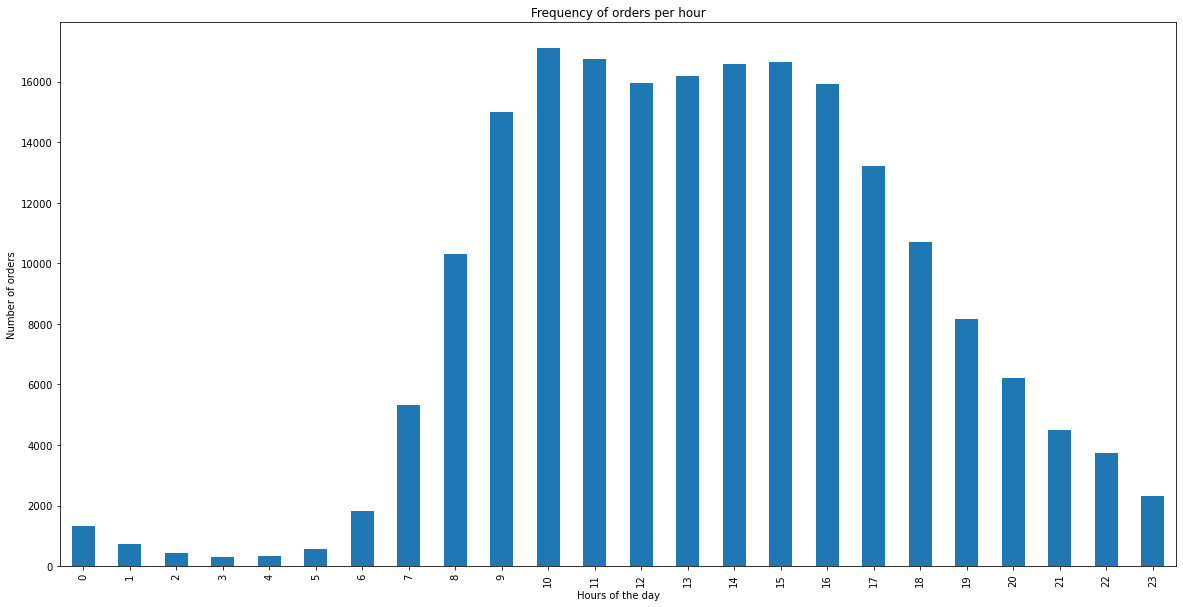

In [4]:
#At what time do we get most orders?
df_merged.drop_duplicates('order_id').groupby('order_hour_of_day')['order_id'].count().plot(kind='bar', 
                                                                                            figsize=(20,10),
                                                                                           title='Frequency of orders per hour',
                                                                                           xlabel='Hours of the day',
                                                                                           ylabel='Number of orders', 
                                                                                           color=color[0])

#### In which days do we get most orders?

<AxesSubplot:title={'center':'Frequency of orders per day of the week'}, xlabel='Days of the week', ylabel='Number of orders'>

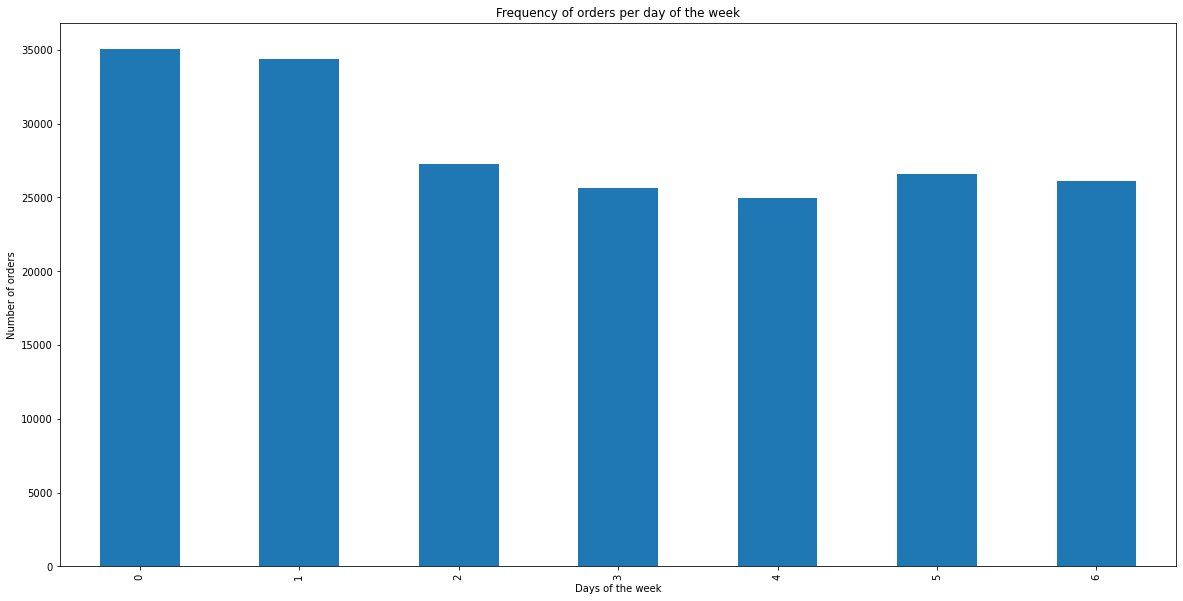

In [5]:
#In which days do we get most orders?
df_merged.drop_duplicates('order_id').groupby('order_dow')['order_id'].count().plot(kind='bar', 
                                                                                            figsize=(20,10),
                                                                                           title='Frequency of orders per day of the week',
                                                                                           xlabel='Days of the week',
                                                                                           ylabel='Number of orders',
                                                                                   color=color[0])

#### How does order frequency change across days of the week and hours of the day?

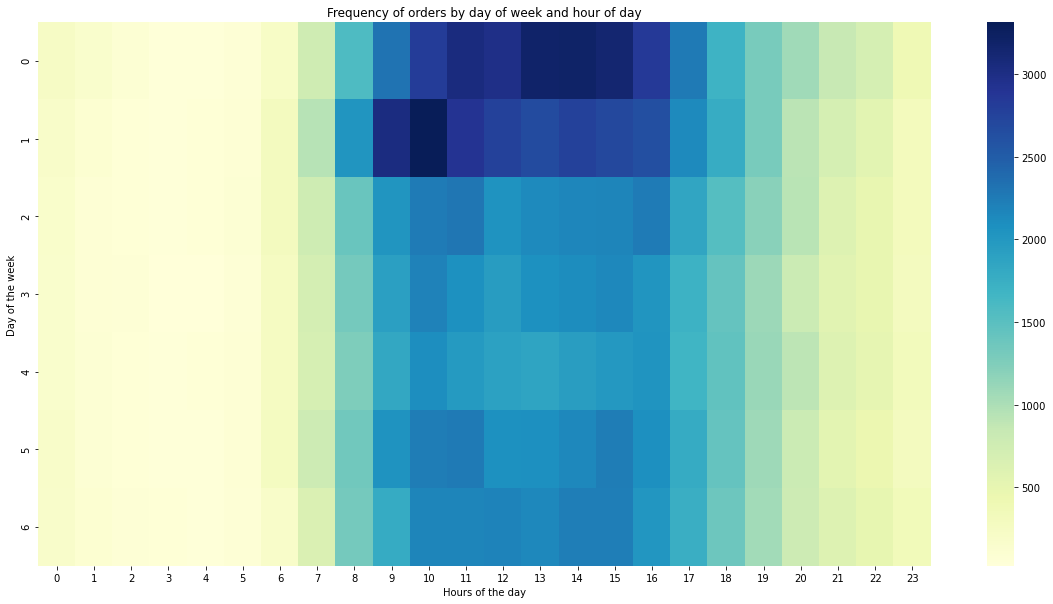

In [6]:
#How does order frequency change across days of the week and hours of the day?
grouped_df = df_merged.drop_duplicates('order_id').groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count")
grouped_df = pd.DataFrame(grouped_df).reset_index().pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(20,10))
sns.heatmap(grouped_df, cmap="YlGnBu")
plt.title("Frequency of orders by day of week and hour of day")
plt.xlabel('Hours of the day')
plt.ylabel('Day of the week')
plt.show()

#### What is the distribution of the number of products per order?

/Users/rui.soromenho/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


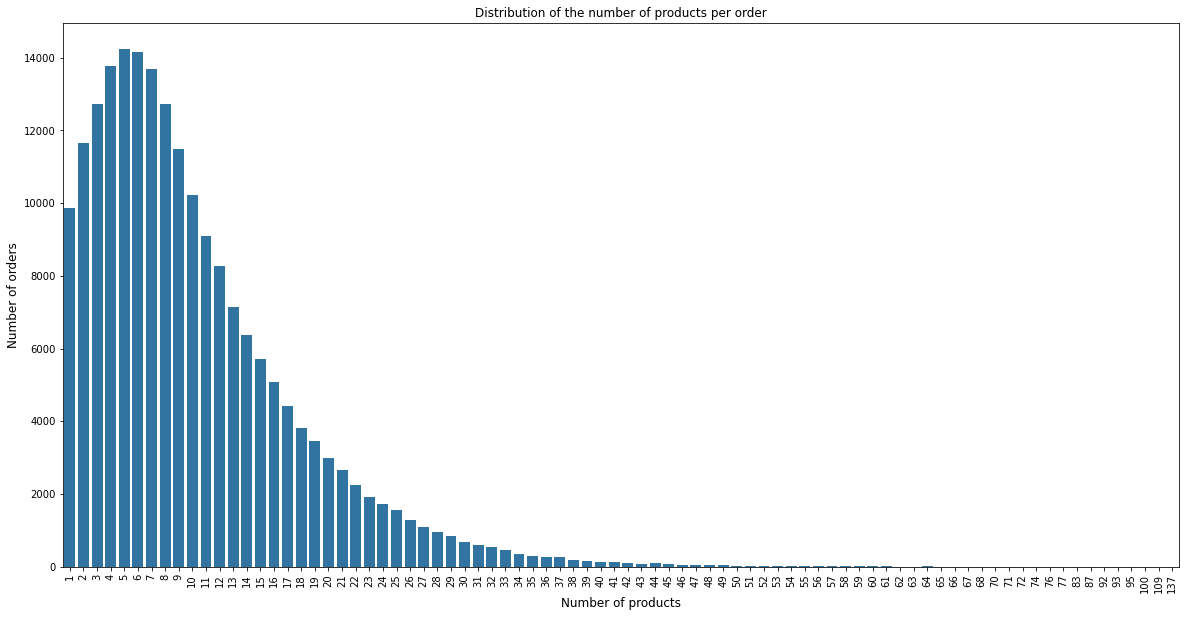

In [7]:
#What is the distribution of the number of products per order?
grouped_df = df_merged.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(20,10))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=1, color=color[0])
plt.title('Distribution of the number of products per order')
plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Number of products', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### What is the distribution of the time between orders?

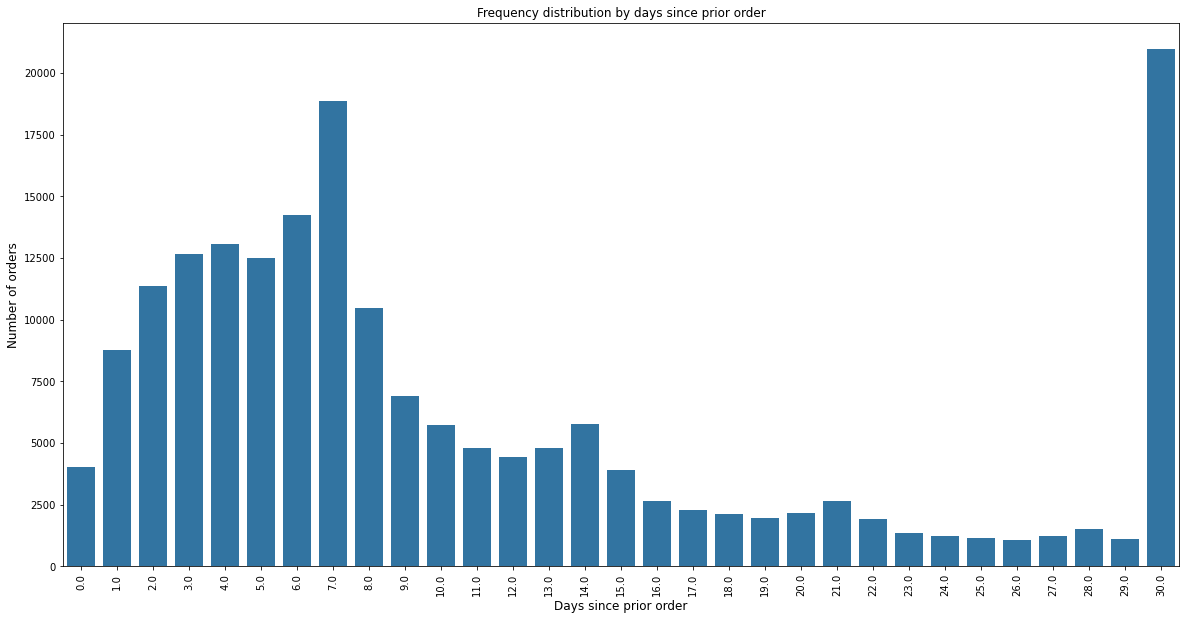

In [8]:
#What is the distribution of the time between orders?
plt.figure(figsize=(20,10))
sns.countplot(x="days_since_prior_order", data=df_merged.drop_duplicates('order_id'), color=color[0])
plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=12)
plt.show()

## User perspective


In [9]:
'''Altought there is only one transaction for customer 7 in the available dataset, 
we can see that this customer has done at least 3 orders'''

df_merged[df_merged['user_id']==7].head()

order_id  product_id  add_to_cart_order  reordered  user_id  \
69398    121053          21                  1          0        7   
69399    121053          59                  2          0        7   
69400    121053          38                  3          0        7   
69401    121053         108                  4          0        7   
69402    121053          24                  5          1        7   

       order_number  order_dow  order_hour_of_day  days_since_prior_order  \
69398             3          0                 18                    30.0   
69399             3          0                 18                    30.0   
69400             3          0                 18                    30.0   
69401             3          0                 18                    30.0   
69402             3          0                 18                    30.0   

       department_id          product_name    department  
69398             16       packaged cheese    dairy eggs  
69399             15    canned meals beans  canned goods  
69400              1          frozen meals        frozen  
69401             16  other creams cheeses    dairy eggs  
69402              4          fresh fruits       produce

#### What is the distribution of the number of orders per user?

<AxesSubplot:title={'center':'Number of orders per user available in the dataset'}, xlabel='Number of orders', ylabel='Number of users'>

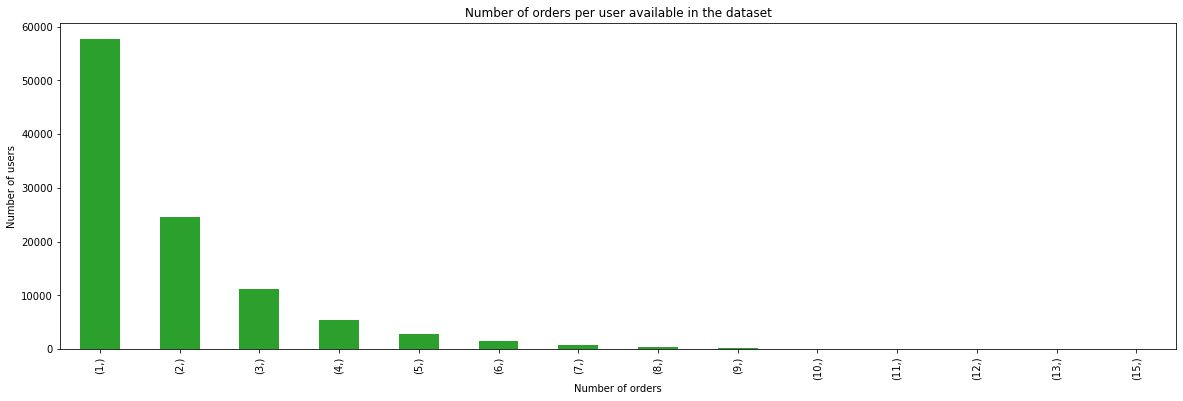

In [10]:
#What is the distribution of the number of orders per user (available in this dataset)?
pd.DataFrame(df_merged.drop_duplicates('order_id').groupby('user_id')['order_id'].count()).sort_values(by='order_id', 
                                                                                                       ascending=False).value_counts().plot(kind='bar', 
                                                                                                                                            figsize=(20,6), 
                
                                                                                           title='Number of orders per user available in the dataset',
                                                                                           xlabel='Number of orders',
                                                                                           ylabel='Number of users',
                                                                                                                                           color=color[2])

/Users/rui.soromenho/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



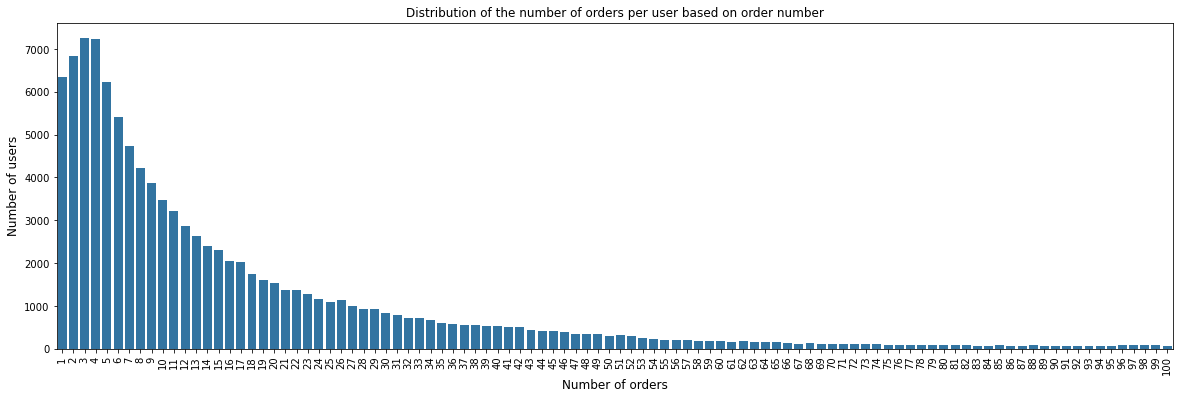

In [54]:
#What is the distribution of the number of orders per user (total)?
grouped_df = df_merged.groupby("user_id")["order_number"].aggregate("max").reset_index()
cnt_srs = grouped_df.order_number.value_counts()

plt.figure(figsize=(20,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=1, color=color[0])
plt.title('Distribution of the number of orders per user based on order number')
plt.ylabel('Number of users', fontsize=12)
plt.xlabel('Number of orders', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### How many users account for 50% of items sold?

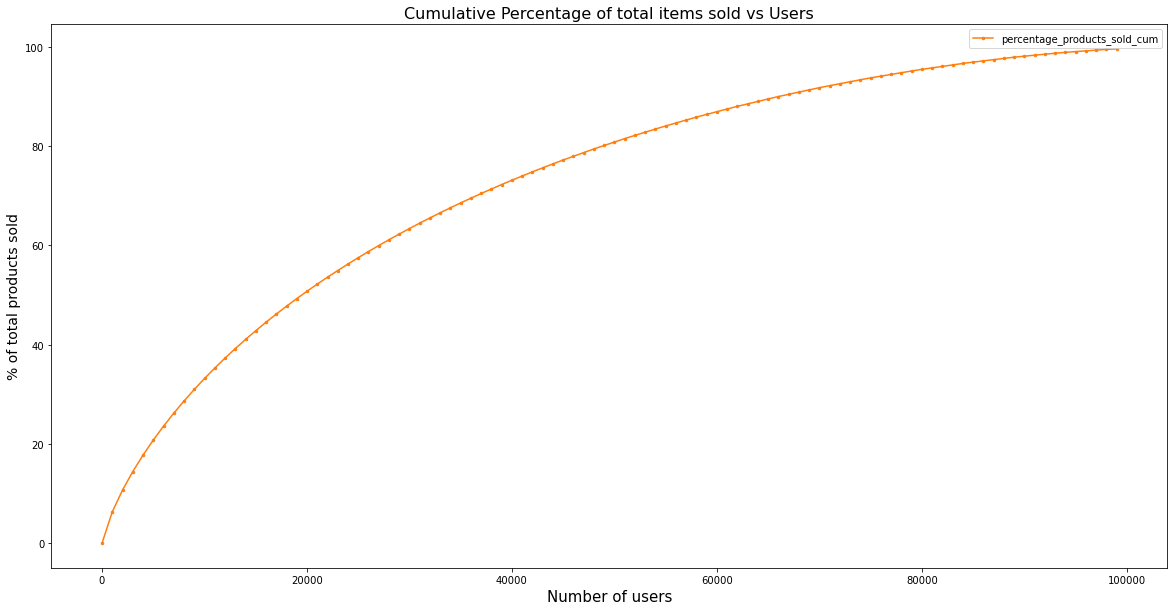

In [12]:
df_user_cum = df_merged.groupby('user_id')['product_id'].count().reset_index().sort_values(by='product_id', ascending=False)
df_user_cum['percentage_products_sold'] = (df_user_cum['product_id']/df_user_cum['product_id'].sum())*100
df_user_cum['percentage_products_sold_cum'] = df_user_cum['percentage_products_sold'].cumsum()
df_user_cum['order'] = [i for i in range(105273)]
df_user_cum

df_user_cum[df_user_cum['order'].isin([i*1000 for i in range(100)])].plot(kind='line', marker='.', x='order', ms=5,
                            y='percentage_products_sold_cum', figsize=(20,10), color=color[1])

plt.title('Cumulative Percentage of total items sold vs Users', fontsize=16)
plt.ylabel('% of total products sold', fontsize=14)
plt.xlabel('Number of users', fontsize=15)
#plt.xticks(ticks=[i for i in range(100)],labels=[i for i in range(100)], rotation='vertical')

plt.show()

#### How many products account for 50% of items sold?

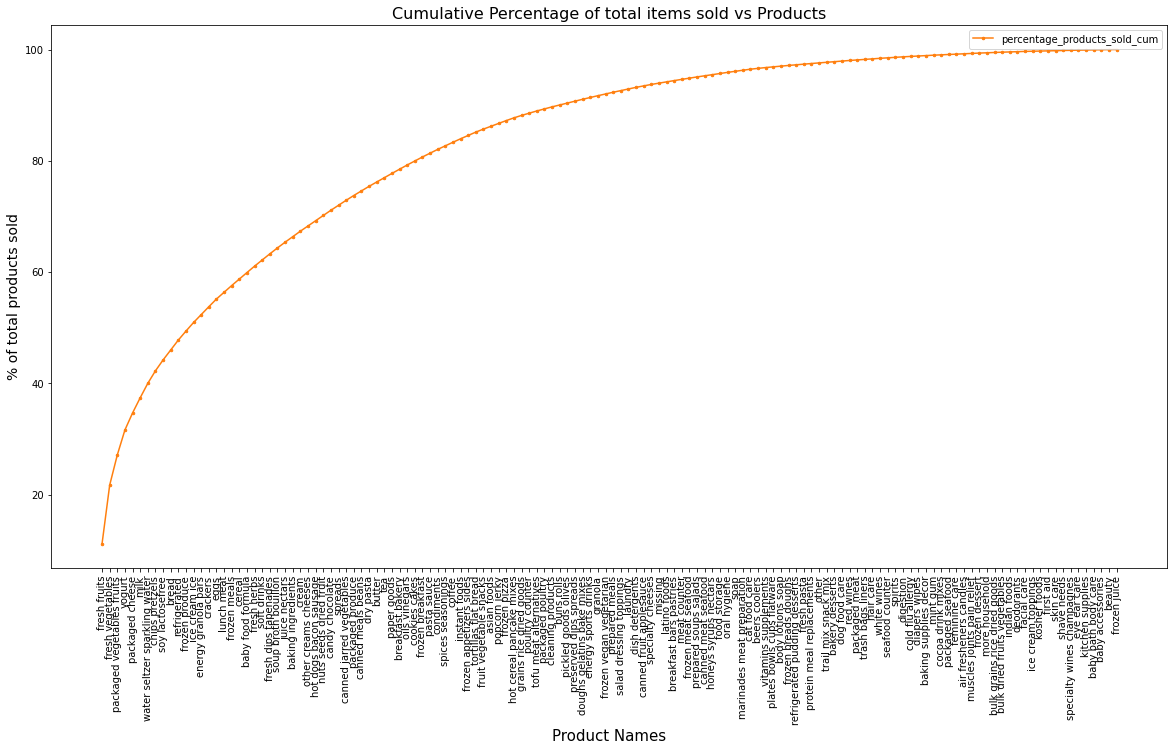

In [13]:
#How many products account for X% of items sold?
df_product_cum = df_merged.groupby('product_name')['product_id'].count().reset_index().sort_values(by='product_id', ascending=False)
sum_ = df_user_cum['product_id'].sum()
df_product_cum['percentage_products_sold'] = (df_product_cum['product_id']/sum_)*100
df_product_cum['percentage_products_sold_cum'] = df_product_cum['percentage_products_sold'].cumsum()
df_product_cum.plot(kind='line', marker='.', x='product_name', ms=5,
                            y='percentage_products_sold_cum', figsize=(20,10), color=color[1])

plt.title('Cumulative Percentage of total items sold vs Products', fontsize=16)
plt.ylabel('% of total products sold', fontsize=14)
plt.xlabel('Product Names', fontsize=15)
plt.xticks(ticks=[i for i in range(134)],labels=df_product_cum['product_name'], rotation='vertical')

plt.show()

#### How many products departments for 50% of items sold?

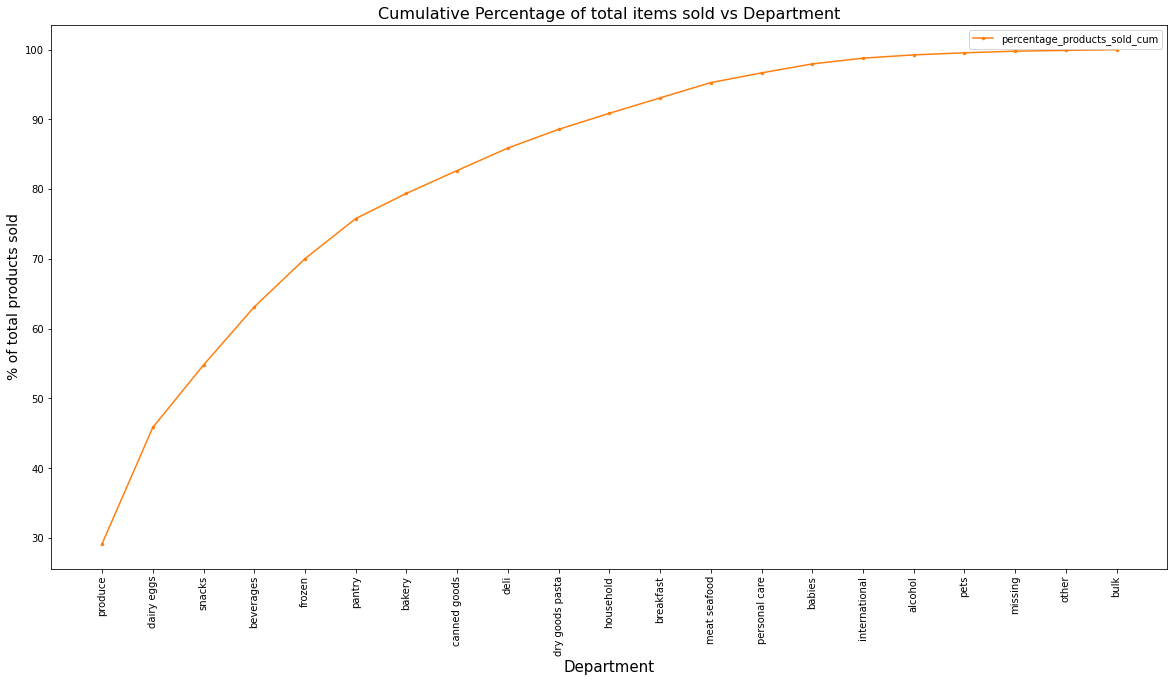

In [14]:
#How many products account for X% of items sold?
df_product_cum = df_merged.groupby('department')['product_id'].count().reset_index().sort_values(by='product_id', ascending=False)
sum_ = df_user_cum['product_id'].sum()
df_product_cum['percentage_products_sold'] = (df_product_cum['product_id']/sum_)*100
df_product_cum['percentage_products_sold_cum'] = df_product_cum['percentage_products_sold'].cumsum()
df_product_cum.plot(kind='line', marker='.', x='department', ms=5,
                            y='percentage_products_sold_cum', figsize=(20,10), color=color[1])

plt.title('Cumulative Percentage of total items sold vs Department', fontsize=16)
plt.ylabel('% of total products sold', fontsize=14)
plt.xlabel('Department', fontsize=15)
plt.xticks(ticks=[i for i in range(21)],labels=df_product_cum['department'], rotation='vertical')

plt.show()

#### How often do users reorder the same items?

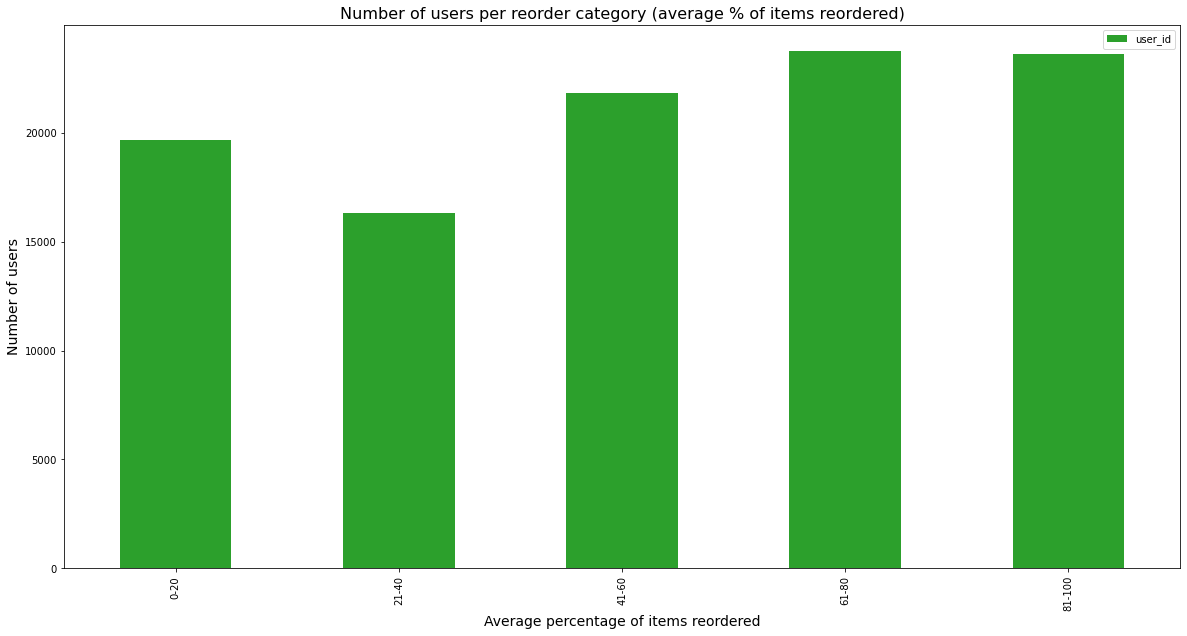

In [15]:
#How often do users reorder the same items?

def reorder_group(x):
    if x<0.21:
        return '0-20'
    if x>0.20 and x<0.41:
        return '21-40'
    if x>0.40 and x<0.61:
        return '41-60'
    if x>0.6 and x<0.81:
        return '61-80'
    if x>0.8:
        return '81-100'

df_reorders_user = df_merged.groupby('user_id')['reordered'].mean().reset_index().sort_values(by='reordered')
df_reorders_user['reorder_group'] = df_reorders_user['reordered'].apply(reorder_group)
df_reorders_user.groupby('reorder_group')['user_id'].count().reset_index().plot(kind='bar', figsize=(20,10),
                                                            x='reorder_group',
                                                         y='user_id', color=color[2])

plt.title('Number of users per reorder category (average % of items reordered)', fontsize=16)
plt.ylabel('Number of users', fontsize=14)
plt.xlabel('Average percentage of items reordered', fontsize=14)

plt.show()

#### What departments tend to have more or less items reordered?

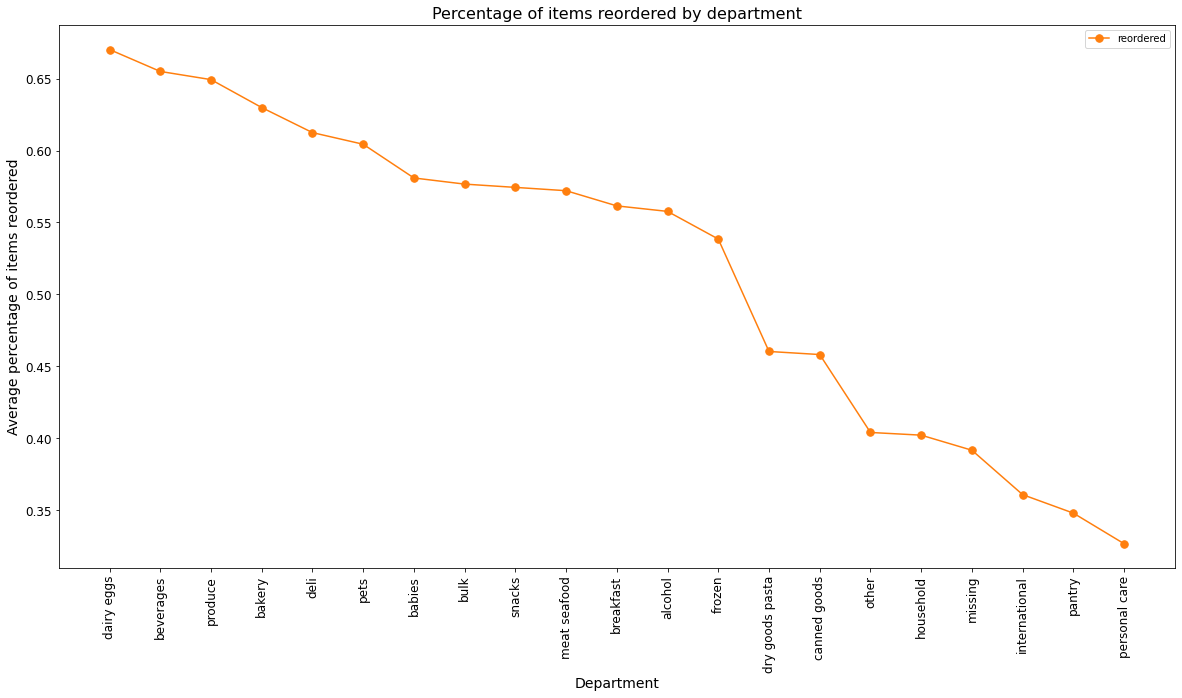

In [40]:
#What departments tend to have more and less items reordered?

df_reorders_department = df_merged.groupby('department')['reordered'].mean().reset_index().sort_values(by='reordered', 
                                                                                                       ascending=False)
df_reorders_department.plot(kind='line', marker='.', x='department', ms=15,
                            y='reordered', figsize=(20,10), color=color[1], fontsize=12)

plt.title('Percentage of items reordered by department', fontsize=16)
plt.ylabel('Average percentage of items reordered', fontsize=14)
plt.xlabel('Department', fontsize=14)
plt.xticks(ticks=[i for i in range(21)],labels=df_reorders_department['department'], rotation='vertical')

plt.show()

## Product perspesctive

#### What is the distribution of sales among departments and products?

In [17]:
df_treemap = df_merged.groupby('product_name')['order_id'].count().reset_index().merge(df_merged[['product_name', 
                                            'department']], on='product_name', how='left').drop_duplicates()

fig = px.treemap(df_treemap, path=['department', 'product_name'], values='order_id',
                  color='department', hover_data=['product_name'],
                  color_continuous_scale='earth', template='simple_white',
                  color_continuous_midpoint=np.average(df_treemap['order_id'], weights=df_treemap['order_id']))

fig.update_layout(title='Distribution of items sold by department and product name')

fig.show()

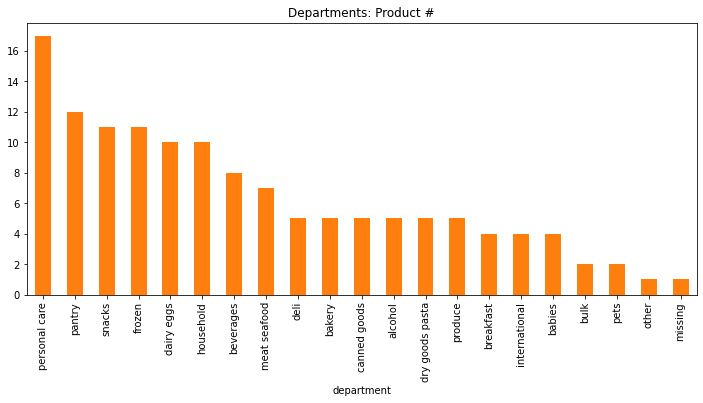

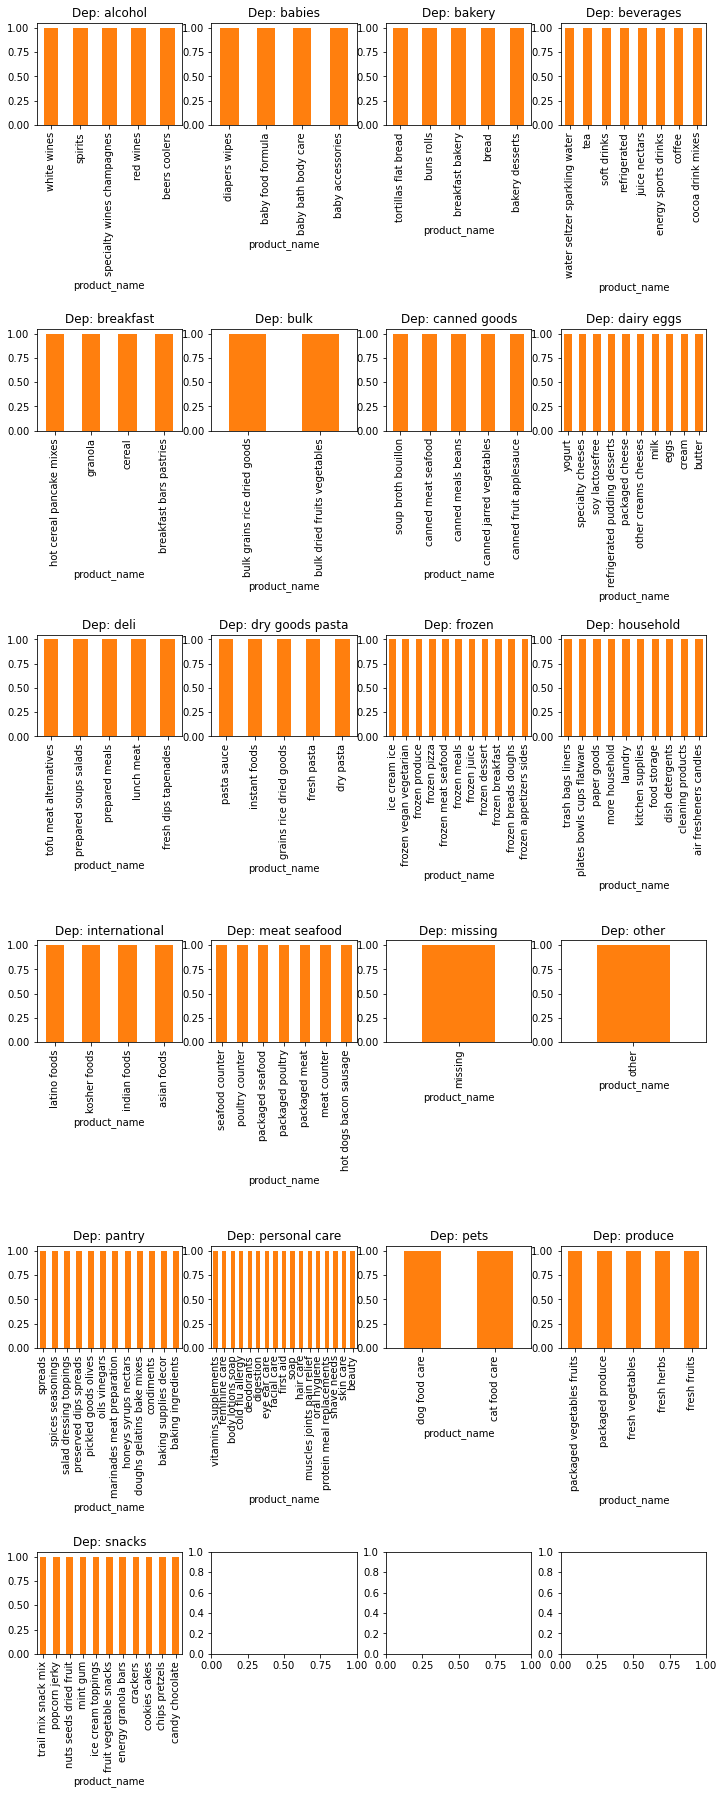

In [18]:
# basic group info (departments)
plt.figure(figsize=(12, 5))
goods.groupby(['department']).count()['product_id'].copy()\
.sort_values(ascending=False).plot(kind='bar', 
                                   color=color[1], 
                                   title='Departments: Product #')

# plot departments volume, split by aisles
f, axarr = plt.subplots(6, 4, figsize=(12, 30))
for i,e in enumerate(departments.department.sort_values(ascending=True)):
    axarr[i//4, i%4].set_title('Dep: {}'.format(e))
    goods[goods.department==e].groupby(['product_name']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar',color=color[1], ax=axarr[i//4, i%4])
f.subplots_adjust(hspace=2)

#### What products are most popular?

/Users/rui.soromenho/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



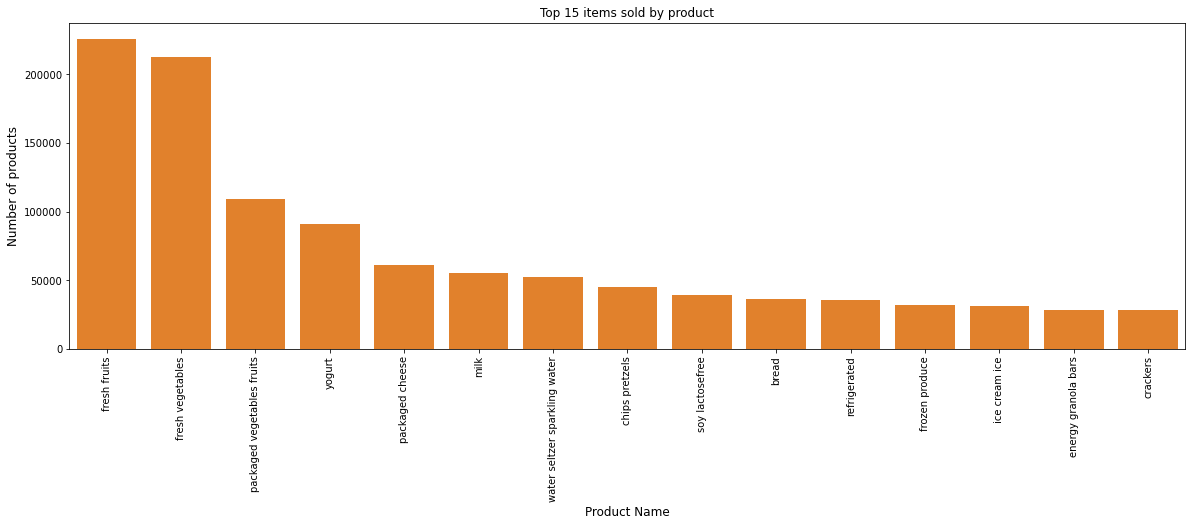

In [19]:
#What products are most popular?
cnt_srs = df_merged['product_name'].value_counts().head(15)
plt.figure(figsize=(20,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=1, color=color[1])
plt.ylabel('Number of products', fontsize=12)
plt.xlabel('Product Name', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Top 15 items sold by product')
plt.show()

#### What products are most frequently bought?

/Users/rui.soromenho/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



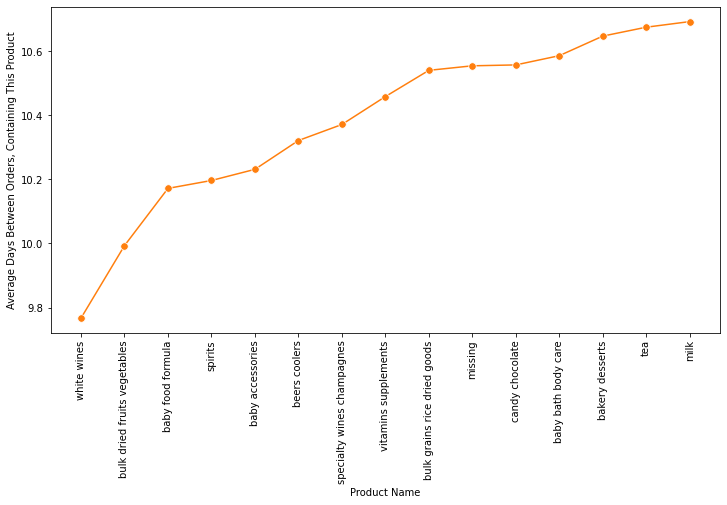

In [58]:
# most "frequently" bought products
# most "frequently" ~ time between orders (within selected customer's orders), 
# that contain that product, is the least 
#(products, which were bought by more than 100 customers, to omit outliers)
top = 15
customer_limit = 100

temp = df_merged.groupby(['product_id'])[['days_since_prior_order', 'user_id']]\
.aggregate({'days_since_prior_order': np.mean, 'user_id': len}).reset_index()

frequent_products = pd.merge(
    left=pd.DataFrame(temp[temp.user_id > customer_limit].sort_values(['days_since_prior_order'], 
                                                                      ascending=True)[:top]),
    right=goods,
    how='left')

plt.figure(figsize=(12,6))
plt.xticks(rotation='vertical')
sns.lineplot(frequent_products.product_name, frequent_products.days_since_prior_order, color=color[1], marker='.',
            markersize=15)
plt.ylabel('Average Days Between Orders, Containing This Product')
plt.xlabel('Product Name')

del temp

#### Products that are the most often added first to the cart

/Users/rui.soromenho/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



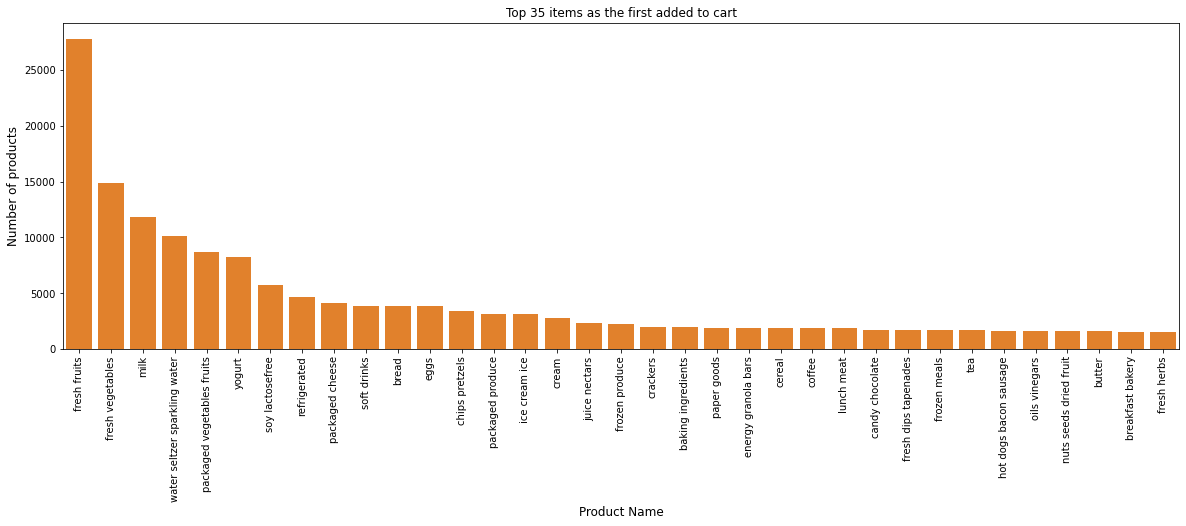

In [21]:
cnt_srs = df_merged[df_merged['add_to_cart_order']<2]['product_name'].value_counts().head(35)
plt.figure(figsize=(20,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=1, color=color[1])
plt.ylabel('Number of products', fontsize=12)
plt.xlabel('Product Name', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Top 35 items as the first added to cart')
plt.show()

/Users/rui.soromenho/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



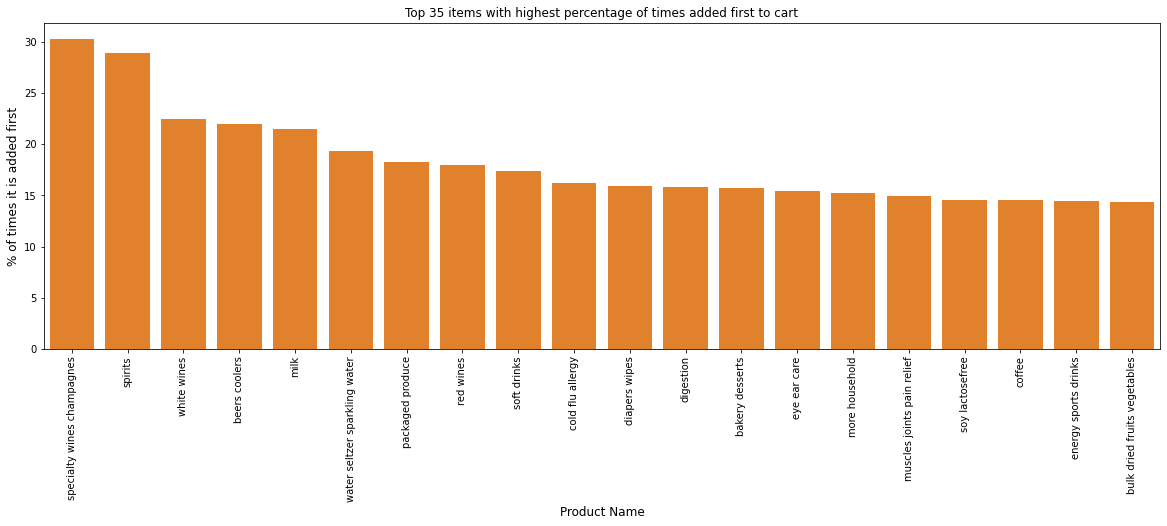

In [59]:
cart_1 = df_merged[df_merged['add_to_cart_order']<2]['product_name'].value_counts()
cart_total = df_merged['product_name'].value_counts().loc[df_merged[df_merged['add_to_cart_order']<2]['product_name'].value_counts().index]
cart_percentage = (cart_1/cart_total)*100
round(cart_percentage.sort_values(ascending=False), 2)

cnt_srs = round(cart_percentage.sort_values(ascending=False)[:20], 2)
plt.figure(figsize=(20,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=1, color=color[1])
plt.ylabel('% of times it is added first', fontsize=12)
plt.xlabel('Product Name', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Top 35 items with highest percentage of times added first to cart')
plt.show()

#### Products with the Highest Reorder Rate

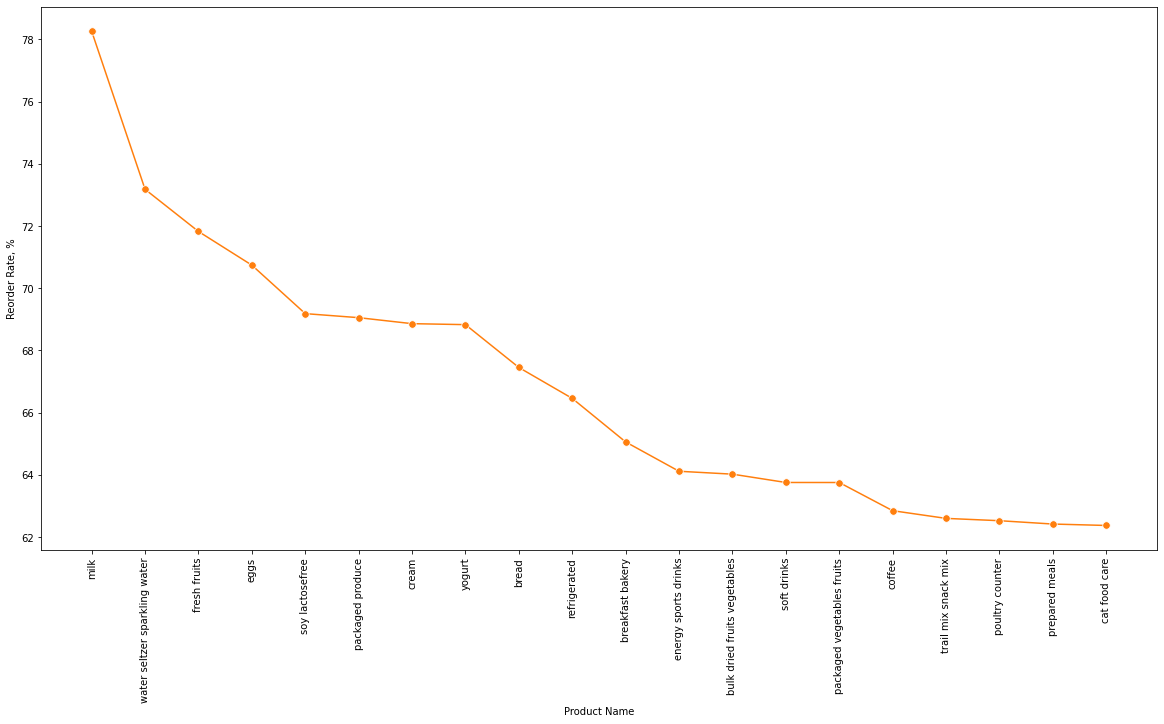

In [53]:
# consider products, purchased in more than X orders
order_limit = 100
top = 20

mo_products = df_merged.groupby('product_id')[['reordered', 'order_id']]\
.aggregate({'reordered': sum, 'order_id': len}).reset_index()
mo_products.columns = ['product_id', 'reordered', 'order_cnt']

mo_products['reorder_rate'] = mo_products['reordered'] / mo_products['order_cnt']
mo_products = mo_products[mo_products.order_cnt > order_limit].sort_values(['reorder_rate'], 
                                                                           ascending=False)[:top]

mo_products = pd.merge(
    left=mo_products,
    right=goods,
    on='product_id')
mo_products

# plot it
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.lineplot(x=mo_products.product_name, y=mo_products.reorder_rate*100, color=color[1], marker='.', markersize=15 )
plt.ylabel('Reorder Rate, %')
plt.xlabel('Product Name')
pass

#### How does the purchasing pattern change across products?

##### Dep: Produce

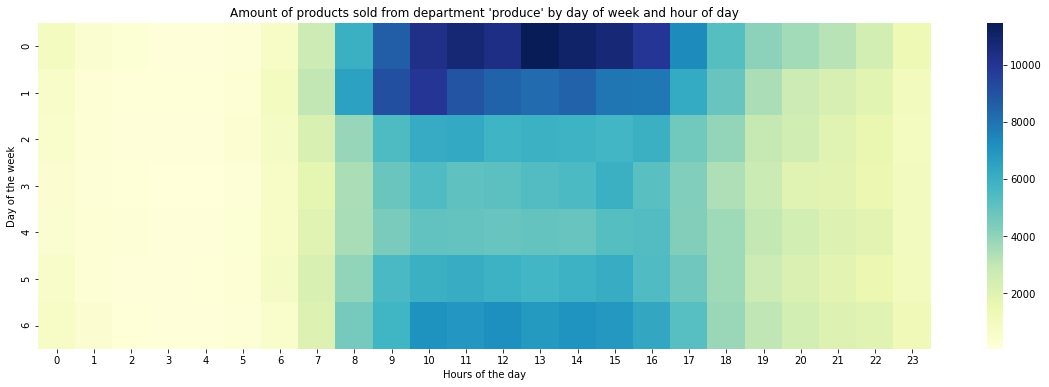

In [24]:
#How does the purchasing pattern change across products?
df_merged_produce = df_merged[df_merged['department']=='produce']
grouped_df = df_merged_produce.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count")
grouped_df = pd.DataFrame(grouped_df).reset_index().pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(20,6))
sns.heatmap(grouped_df, cmap="YlGnBu")
plt.title("Amount of products sold from department 'produce' by day of week and hour of day")
plt.xlabel('Hours of the day')
plt.ylabel('Day of the week')
plt.show()

##### Dep: Household

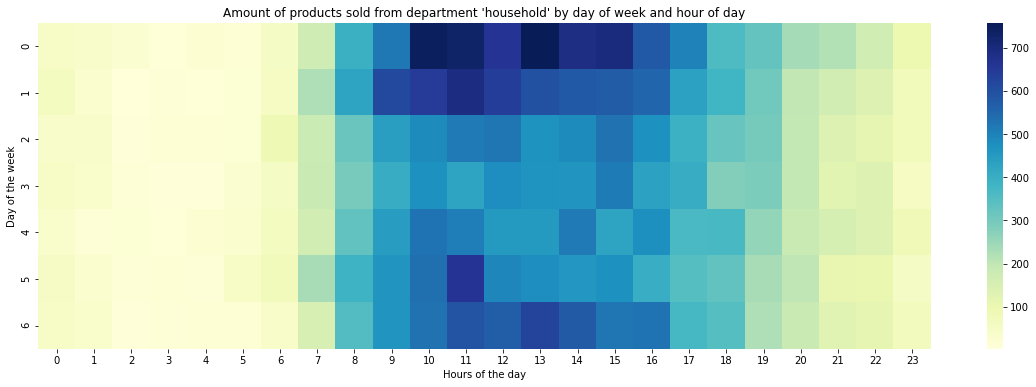

In [25]:
#What does the purchasing pattern change across products?
df_merged_produce = df_merged[df_merged['department']=='household']
grouped_df = df_merged_produce.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count")
grouped_df = pd.DataFrame(grouped_df).reset_index().pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(20,6))
sns.heatmap(grouped_df, cmap="YlGnBu")
plt.title("Amount of products sold from department 'household' by day of week and hour of day")
plt.xlabel('Hours of the day')
plt.ylabel('Day of the week')
plt.show()

##### Dep: Breakfast

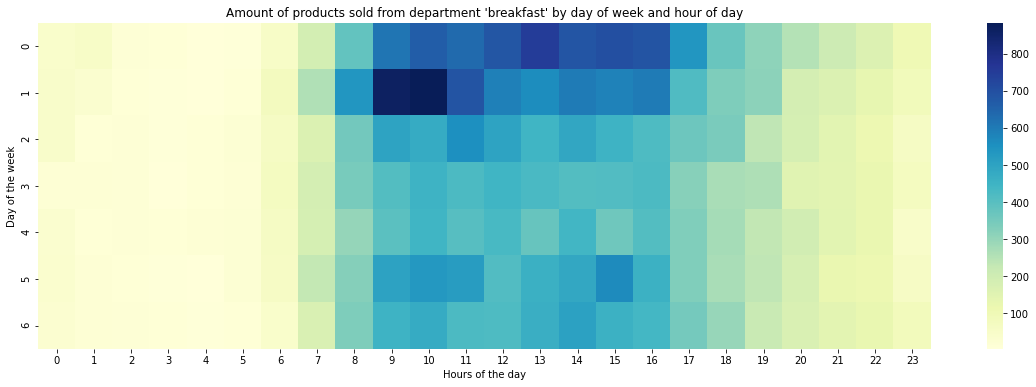

In [26]:
#What does the purchasing pattern change across products?
df_merged_produce = df_merged[df_merged['department']=='breakfast']
grouped_df = df_merged_produce.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count")
grouped_df = pd.DataFrame(grouped_df).reset_index().pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(20,6))
sns.heatmap(grouped_df, cmap="YlGnBu")
plt.title("Amount of products sold from department 'breakfast' by day of week and hour of day")
plt.xlabel('Hours of the day')
plt.ylabel('Day of the week')
plt.show()

##### Dep: Alcohol

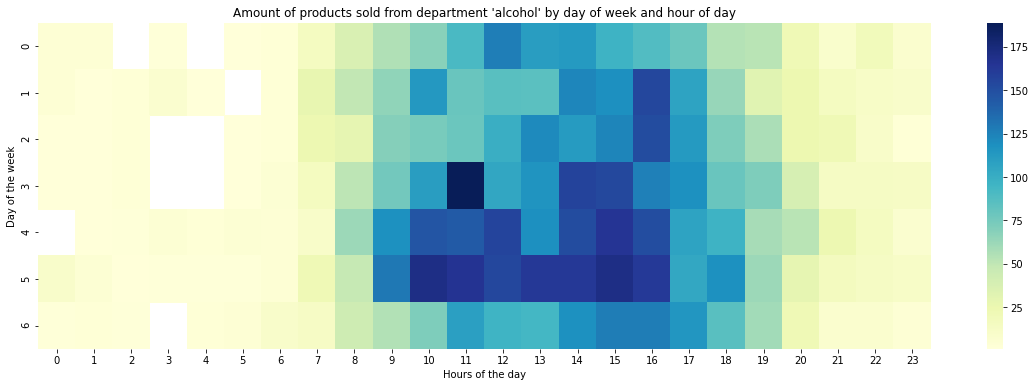

In [27]:
df_merged_produce = df_merged[df_merged['department']=='alcohol']
grouped_df = df_merged_produce.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count")
grouped_df = pd.DataFrame(grouped_df).reset_index().pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(20,6))
sns.heatmap(grouped_df, cmap="YlGnBu")
plt.title("Amount of products sold from department 'alcohol' by day of week and hour of day")
plt.xlabel('Hours of the day')
plt.ylabel('Day of the week')
plt.show()

##### Dep: Babies

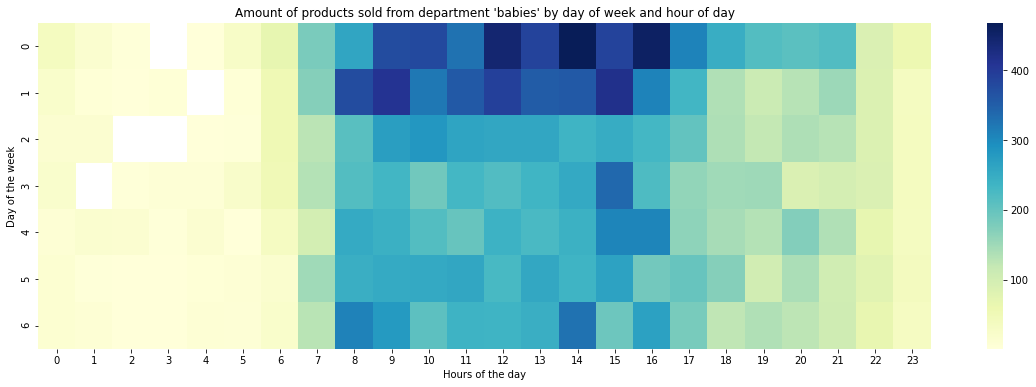

In [28]:
df_merged_produce = df_merged[df_merged['department']=='babies']
grouped_df = df_merged_produce.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count")
grouped_df = pd.DataFrame(grouped_df).reset_index().pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(20,6))
sns.heatmap(grouped_df, cmap="YlGnBu")
plt.title("Amount of products sold from department 'babies' by day of week and hour of day")
plt.xlabel('Hours of the day')
plt.ylabel('Day of the week')
plt.show()